In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib agg

import visualization
from data import datasets
import numpy as np
import jax
import jax.numpy as jnp
from jax.tree_util import tree_map, tree_flatten, tree_unflatten, tree_leaves
import flax.linen as nn
from flax.core import freeze, unfreeze
from typing import Sequence
from functools import reduce
from itertools import combinations_with_replacement, product
import matplotlib.pyplot as plt

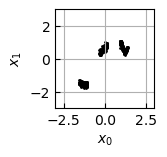

In [2]:
# load dataset
rng_key = jax.random.PRNGKey(23)
data_key, split_key = jax.random.split(rng_key)
#dataset = datasets.Sinusoidal(normalization="standardization", rng_key=data_key, x_lower=0.0, x_upper=6.0)
dataset = datasets.Izmailov(normalization="standardization")
dataset_train, dataset_validate = dataset.split(split_key, 0.9)
X_train, y_train = dataset_train[:]
figure = visualization.TriangleFigure(prefix="x", settings=visualization.TriangleSettings(univariate=False))
figure.plot(data=dataset_train.data)

In [3]:
# load samples
parameters_samples = np.load("ws_mlp_3_1_izmailov.npy")
print(parameters_samples.shape)

(49152, 10)


In [4]:
from itertools import permutations

class MLP(nn.Module):
    features: Sequence[int]
    
    @nn.compact
    def __call__(self, x):
        for i, feature in enumerate(self.features[:-1]):
            x = nn.tanh(nn.Dense(feature, use_bias=True, kernel_init=nn.initializers.zeros, bias_init=nn.initializers.zeros, name=f"dense_{i}")(x))
        x = nn.Dense(self.features[-1], kernel_init=nn.initializers.zeros, bias_init=nn.initializers.zeros, name=f"dense_{i + 1}")(x)
        return x
    
    def parameters_size(self, inputs):
        parameters = self.init(jax.random.PRNGKey(0), inputs)
        leaves, treedef = tree_flatten(parameters)
        l = sum([reduce(lambda x, y: x * y, leaf.shape) for leaf in leaves])
        return l
    
    def init_from_vector(self, inputs, parameters_vector):
        parameters = self.init(jax.random.PRNGKey(0), inputs)  # I do not need random behaviour here.
        leaves, treedef = tree_flatten(parameters)
        new_leaves = []
        accumulator = 0
        for leaf in leaves:
            size = reduce(lambda x, y: x * y, [s for s in leaf.shape])
            new_leaves.append(parameters_vector[accumulator:accumulator + size].reshape(leaf.shape))
            accumulator += size
        new_parameters = tree_unflatten(treedef, new_leaves)
        return new_parameters
    
    def apply_from_vector(self, inputs, parameters):
        v = self.init_from_vector(inputs=inputs, parameters_vector=parameters)
        return self.apply(v, inputs)
neural_network = MLP([3, 1])

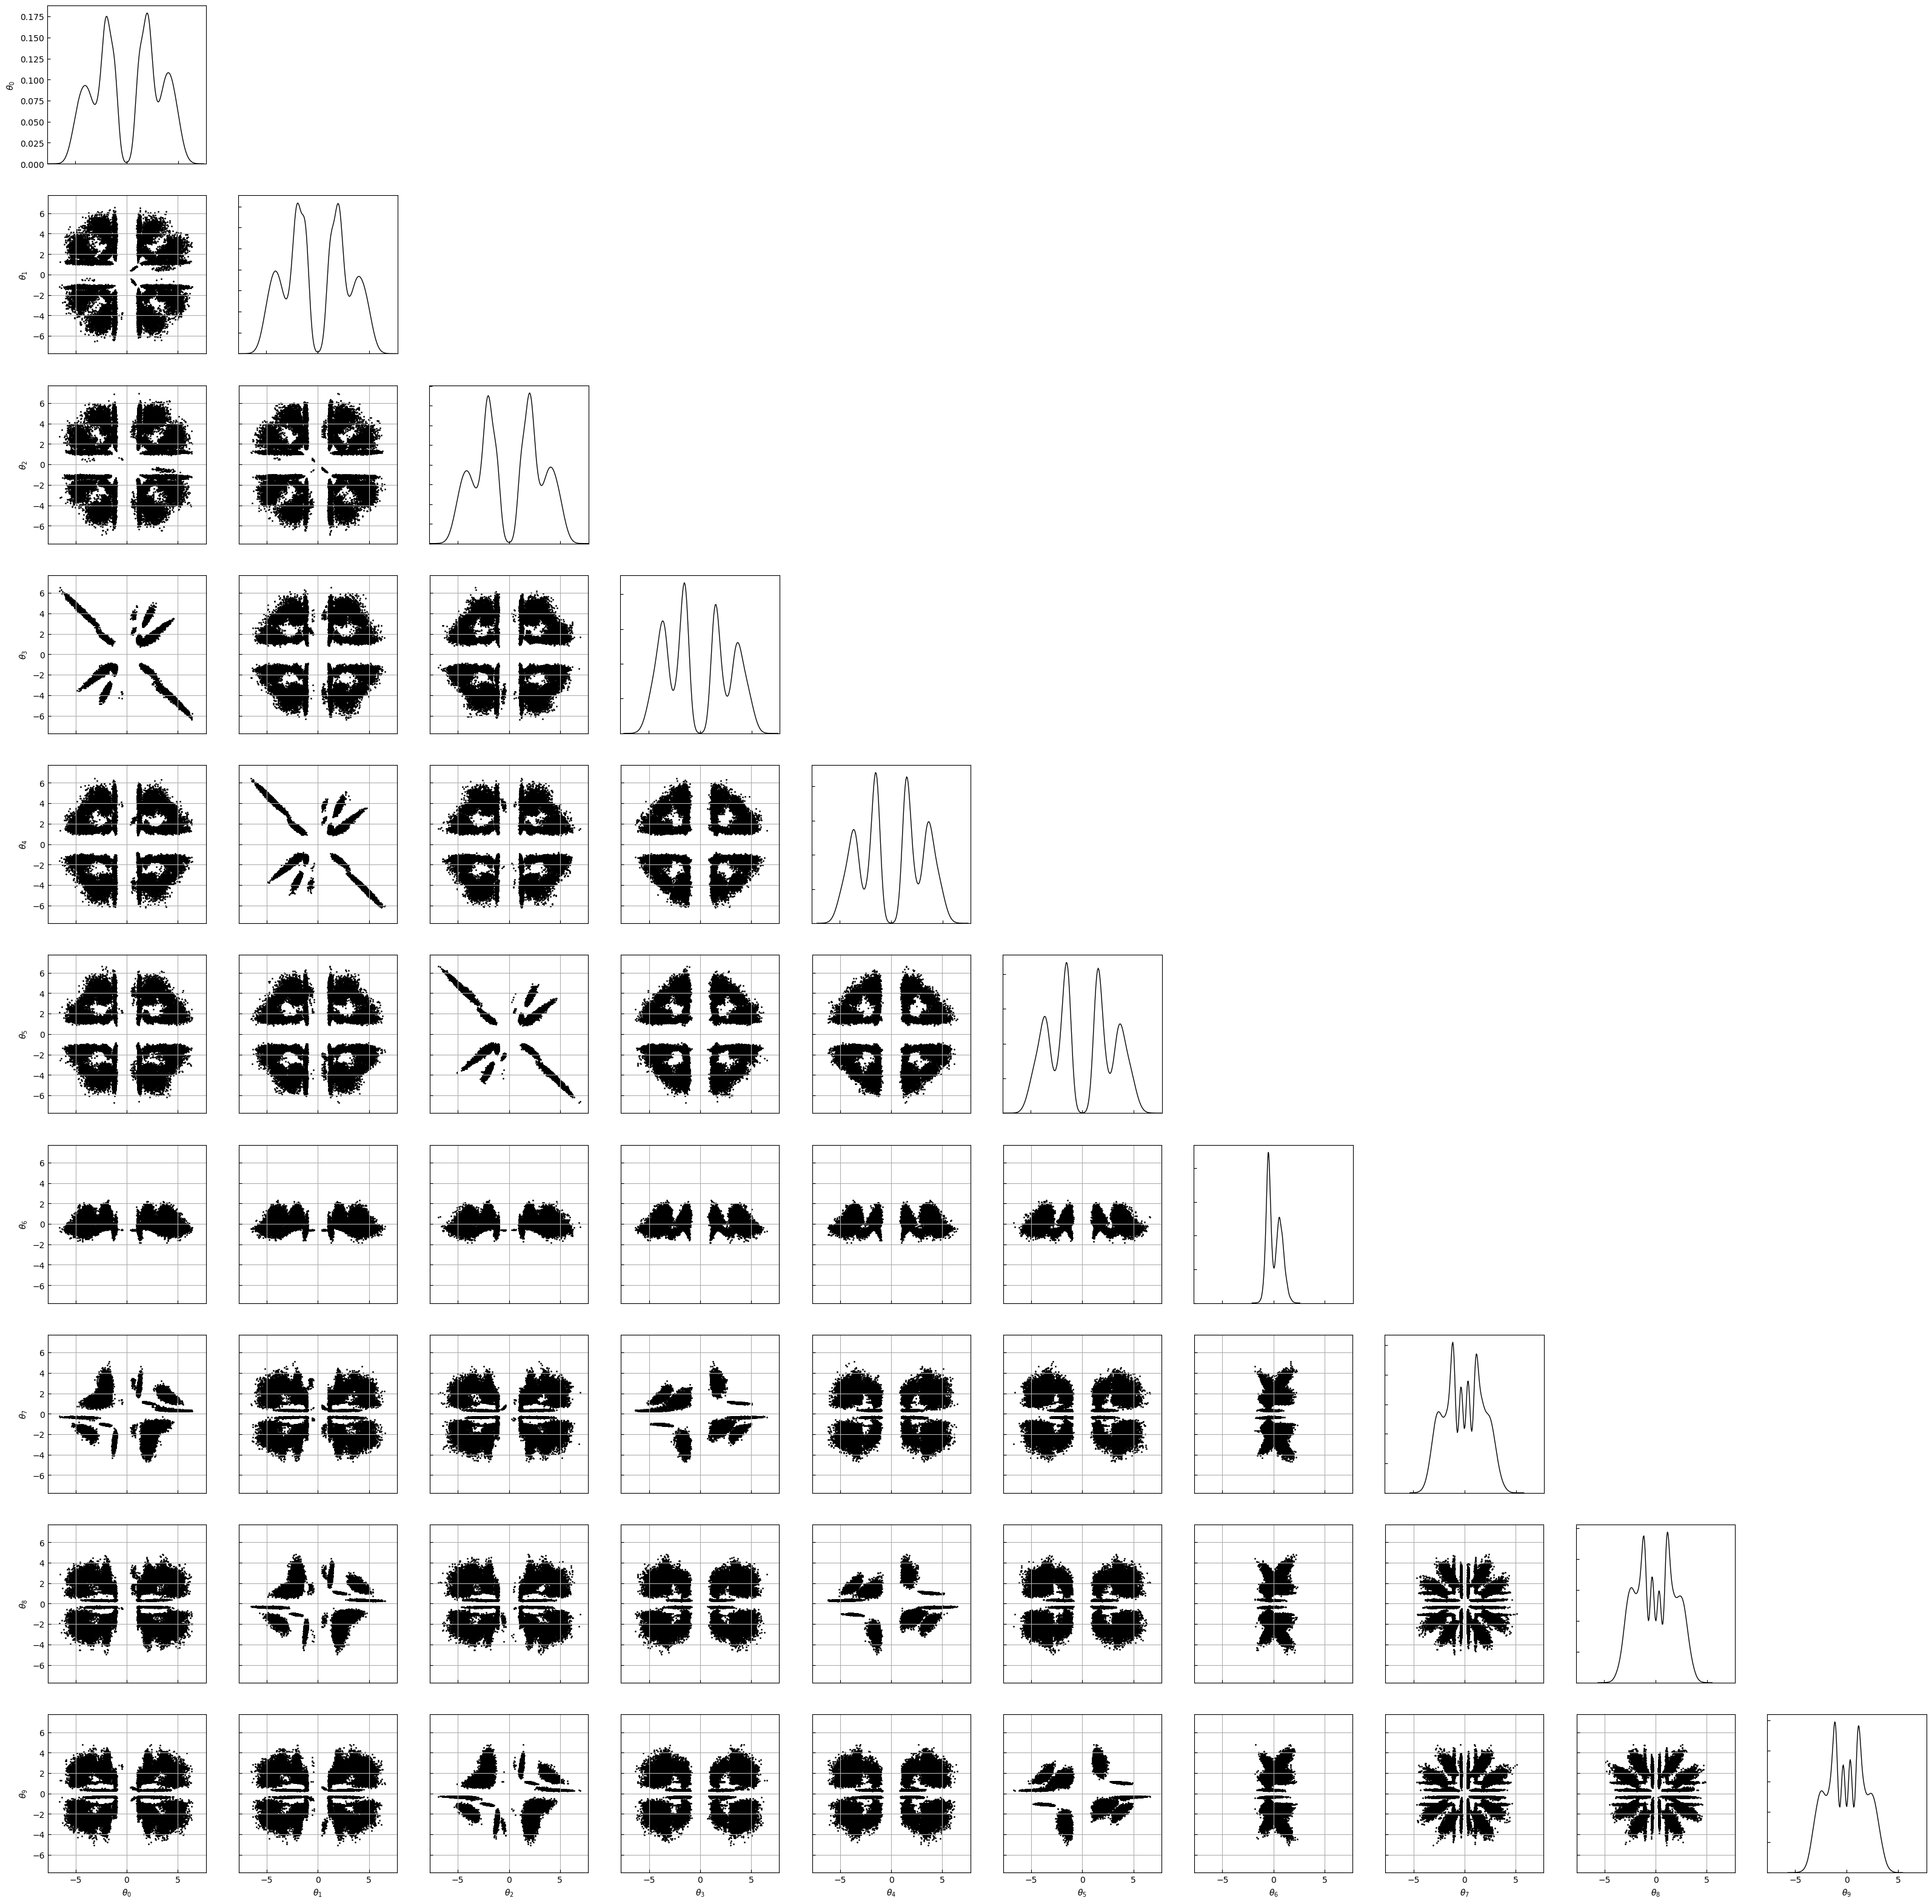

In [5]:
figure = visualization.TriangleFigure(
    prefix=r"\theta",
    ax_width=4.0,
    ax_height=4.0,
    settings=visualization.TriangleSettings(
        scatter_settings=visualization.ScatterSettings(alpha=1.0, size=1.0)
    )
)
figure.plot(data=parameters_samples)

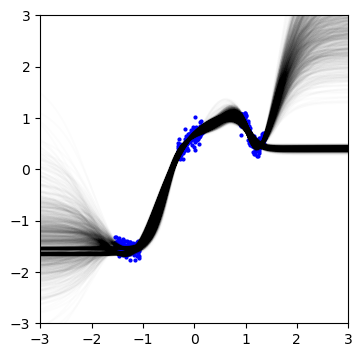

In [9]:
figure = visualization.RegressionFigure()
figure.plot(data=dataset_train.data, transformation=neural_network.apply_from_vector, parameters=parameters_samples[:2048], std=0.1)

In [10]:
# apparently i have to remove tanh symmetries first, then permutation symmetries to obtain a single mode.

class MLPSymmetryHelper:
    # so far only works for single hidden layer MLPs
    def __init__(self, parameters_shapes, activation_function):
        self._parameters_shapes = parameters_shapes
        self._activation_function = activation_function
    
    def activation_symmetries(self):
        parameters_count = sum(tree_leaves(tree_map(lambda leaf: reduce(lambda a, b: a * b, leaf), self._parameters_shapes)))
        layer_keys = list(self._parameters_shapes["params"].keys())
        result_transformations = []
        index = 0
        for i, layer_key in enumerate(layer_keys[:-1]):
            layer_shapes = self._parameters_shapes["params"][layer_keys[i]]
            following_layer_shapes = self._parameters_shapes["params"][layer_keys[i + 1]]
            bias_shape = layer_shapes["bias"]
            kernel_shape = layer_shapes["kernel"]
            following_bias_shape = following_layer_shapes["bias"]
            following_kernel_shape = following_layer_shapes["kernel"]
            symmetries = list(product([-1, 1], repeat=bias_shape[0]))
            
            for symmetry in symmetries:
                transformation_diagonal = np.ones(parameters_count)
                j = index
                
                bias = np.array(symmetry)
                old_j = j
                j += bias.flatten().shape[0]
                transformation_diagonal[old_j:j] = bias
                
                kernel = np.stack([symmetry] * kernel_shape[0], axis=0)
                old_j = j
                j += kernel.flatten().shape[0]
                transformation_diagonal[old_j:j] = kernel.flatten()
                
                following_kernel = np.stack([symmetry] * following_kernel_shape[1], axis=1)
                old_j = j + following_bias_shape[0]
                j += following_kernel.flatten().shape[0] + following_bias_shape[0]
                transformation_diagonal[old_j:j] = following_kernel.flatten()
                
                result_transformations.append(np.diag(transformation_diagonal))
            index += reduce(lambda a, b: a * b, bias_shape) + reduce(lambda a, b: a * b, kernel_shape)
            
        return np.array(result_transformations)
        
    def permutation_symmetries(self):
        parameters_count = sum(tree_leaves(tree_map(lambda leaf: reduce(lambda a, b: a * b, leaf), self._parameters_shapes)))
        leaves, treedef = tree_flatten(self._parameters_shapes)
        
        # construct tree of parameters indices
        leaves_indices = []
        i = 0
        for leaf in leaves:
            size = reduce(lambda a, b: a * b, leaf)
            leaves_indices.append(np.arange(parameters_count)[i:i + size].reshape(leaf))
            i += size
        parameters_indices = tree_unflatten(treedef, leaves_indices)
        
        # collect all transformations
        layer_keys = list(self._parameters_shapes["params"].keys())
        result_transformations = []
        index = 0
        for i, layer_key in enumerate(layer_keys[:-1]):
            layer_indices = parameters_indices["params"][layer_keys[i]]
            following_layer_indices = parameters_indices["params"][layer_keys[i + 1]]
            bias_indices = layer_indices["bias"]
            kernel_indices = layer_indices["kernel"]
            following_bias_indices = following_layer_indices["bias"]
            following_kernel_indices = following_layer_indices["kernel"]
            size = bias_indices.shape[0] + following_bias_indices.shape[0] + reduce(lambda a, b: a * b, kernel_indices.shape) + reduce(lambda a, b: a * b, following_kernel_indices.shape)
            
            permutation_matrix = np.eye(bias_indices.shape[0])
            permutation_matrices = np.array(list(permutations(permutation_matrix)))
            permutation_count = permutation_matrices.shape[0]
            
            bias_indices_permuted = permutation_matrices @ bias_indices
            kernel_indices_permuted = permutation_matrices @ kernel_indices.T
            following_bias_indices_permuted = np.stack([following_bias_indices] * permutation_count, axis=0)
            following_kernel_indices_permuted = permutation_matrices @ following_kernel_indices
            
            indices_stacked = np.concatenate([bias_indices_permuted, kernel_indices_permuted.reshape((permutation_count, -1)), following_bias_indices_permuted, following_kernel_indices_permuted.reshape((permutation_count, -1))], axis=-1)
            indices_permuted = np.stack([np.arange(parameters_count)] * permutation_count)
            indices_permuted[:, index:size] = indices_stacked
            index += size
            
            for element in indices_permuted:
                result_transformations.append(np.eye(element.shape[0])[element].T)
            
        return np.array(result_transformations)

In [11]:
sh = MLPSymmetryHelper(
    parameters_shapes=unfreeze(tree_map(lambda x: np.array(x.shape), neural_network.init_from_vector(inputs=np.ones((1, 1)), parameters_vector=parameters_samples[0]))),
    activation_function="tanh"
)

In [12]:
activation_symmetries = sh.activation_symmetries()
permutation_symmetries = sh.permutation_symmetries()

In [13]:
# maybe the three clusters have different NN representations for fitting the data. Investigate!

In [14]:
mirrored_parameters_samples = []
for i, parameters_sample in enumerate(parameters_samples):
    mirrored_parameters_sample = parameters_sample.copy()
    
    # MLP ([3, 1])
    # permutation symmetries
    biases_1 = mirrored_parameters_sample[0:3]
    kernel_1 = mirrored_parameters_sample[3:6]
    kernel_2 = mirrored_parameters_sample[7:]
    
    biases_1_indices_sort = np.argsort(biases_1)
    biases_1 = biases_1[biases_1_indices_sort]
    kernel_1 = kernel_1[biases_1_indices_sort]
    kernel_2 = kernel_2[biases_1_indices_sort]
    
    mirrored_parameters_sample[0:3] = biases_1
    mirrored_parameters_sample[3:6] = kernel_1
    mirrored_parameters_sample[7:] = kernel_2
    
    # tanh symmetries
    if mirrored_parameters_sample[3] < 0.0:
        mirrored_parameters_sample[[0, 3, 7]] *= -1.0
    if mirrored_parameters_sample[4] < 0.0:
        mirrored_parameters_sample[[1, 4, 8]] *= -1.0
    if mirrored_parameters_sample[5] < 0.0:
        mirrored_parameters_sample[[2, 5, 9]] *= -1.0
    
    # permutation symmetries
    biases_1 = mirrored_parameters_sample[0:3]
    kernel_1 = mirrored_parameters_sample[3:6]
    kernel_2 = mirrored_parameters_sample[7:]
    
    biases_1_indices_sort = np.argsort(biases_1)
    biases_1 = biases_1[biases_1_indices_sort]
    kernel_1 = kernel_1[biases_1_indices_sort]
    kernel_2 = kernel_2[biases_1_indices_sort]
    
    mirrored_parameters_sample[0:3] = biases_1
    mirrored_parameters_sample[3:6] = kernel_1
    mirrored_parameters_sample[7:] = kernel_2
    
    mirrored_parameters_samples.append(mirrored_parameters_sample)
mirrored_parameters_samples = np.stack(mirrored_parameters_samples, axis=0)

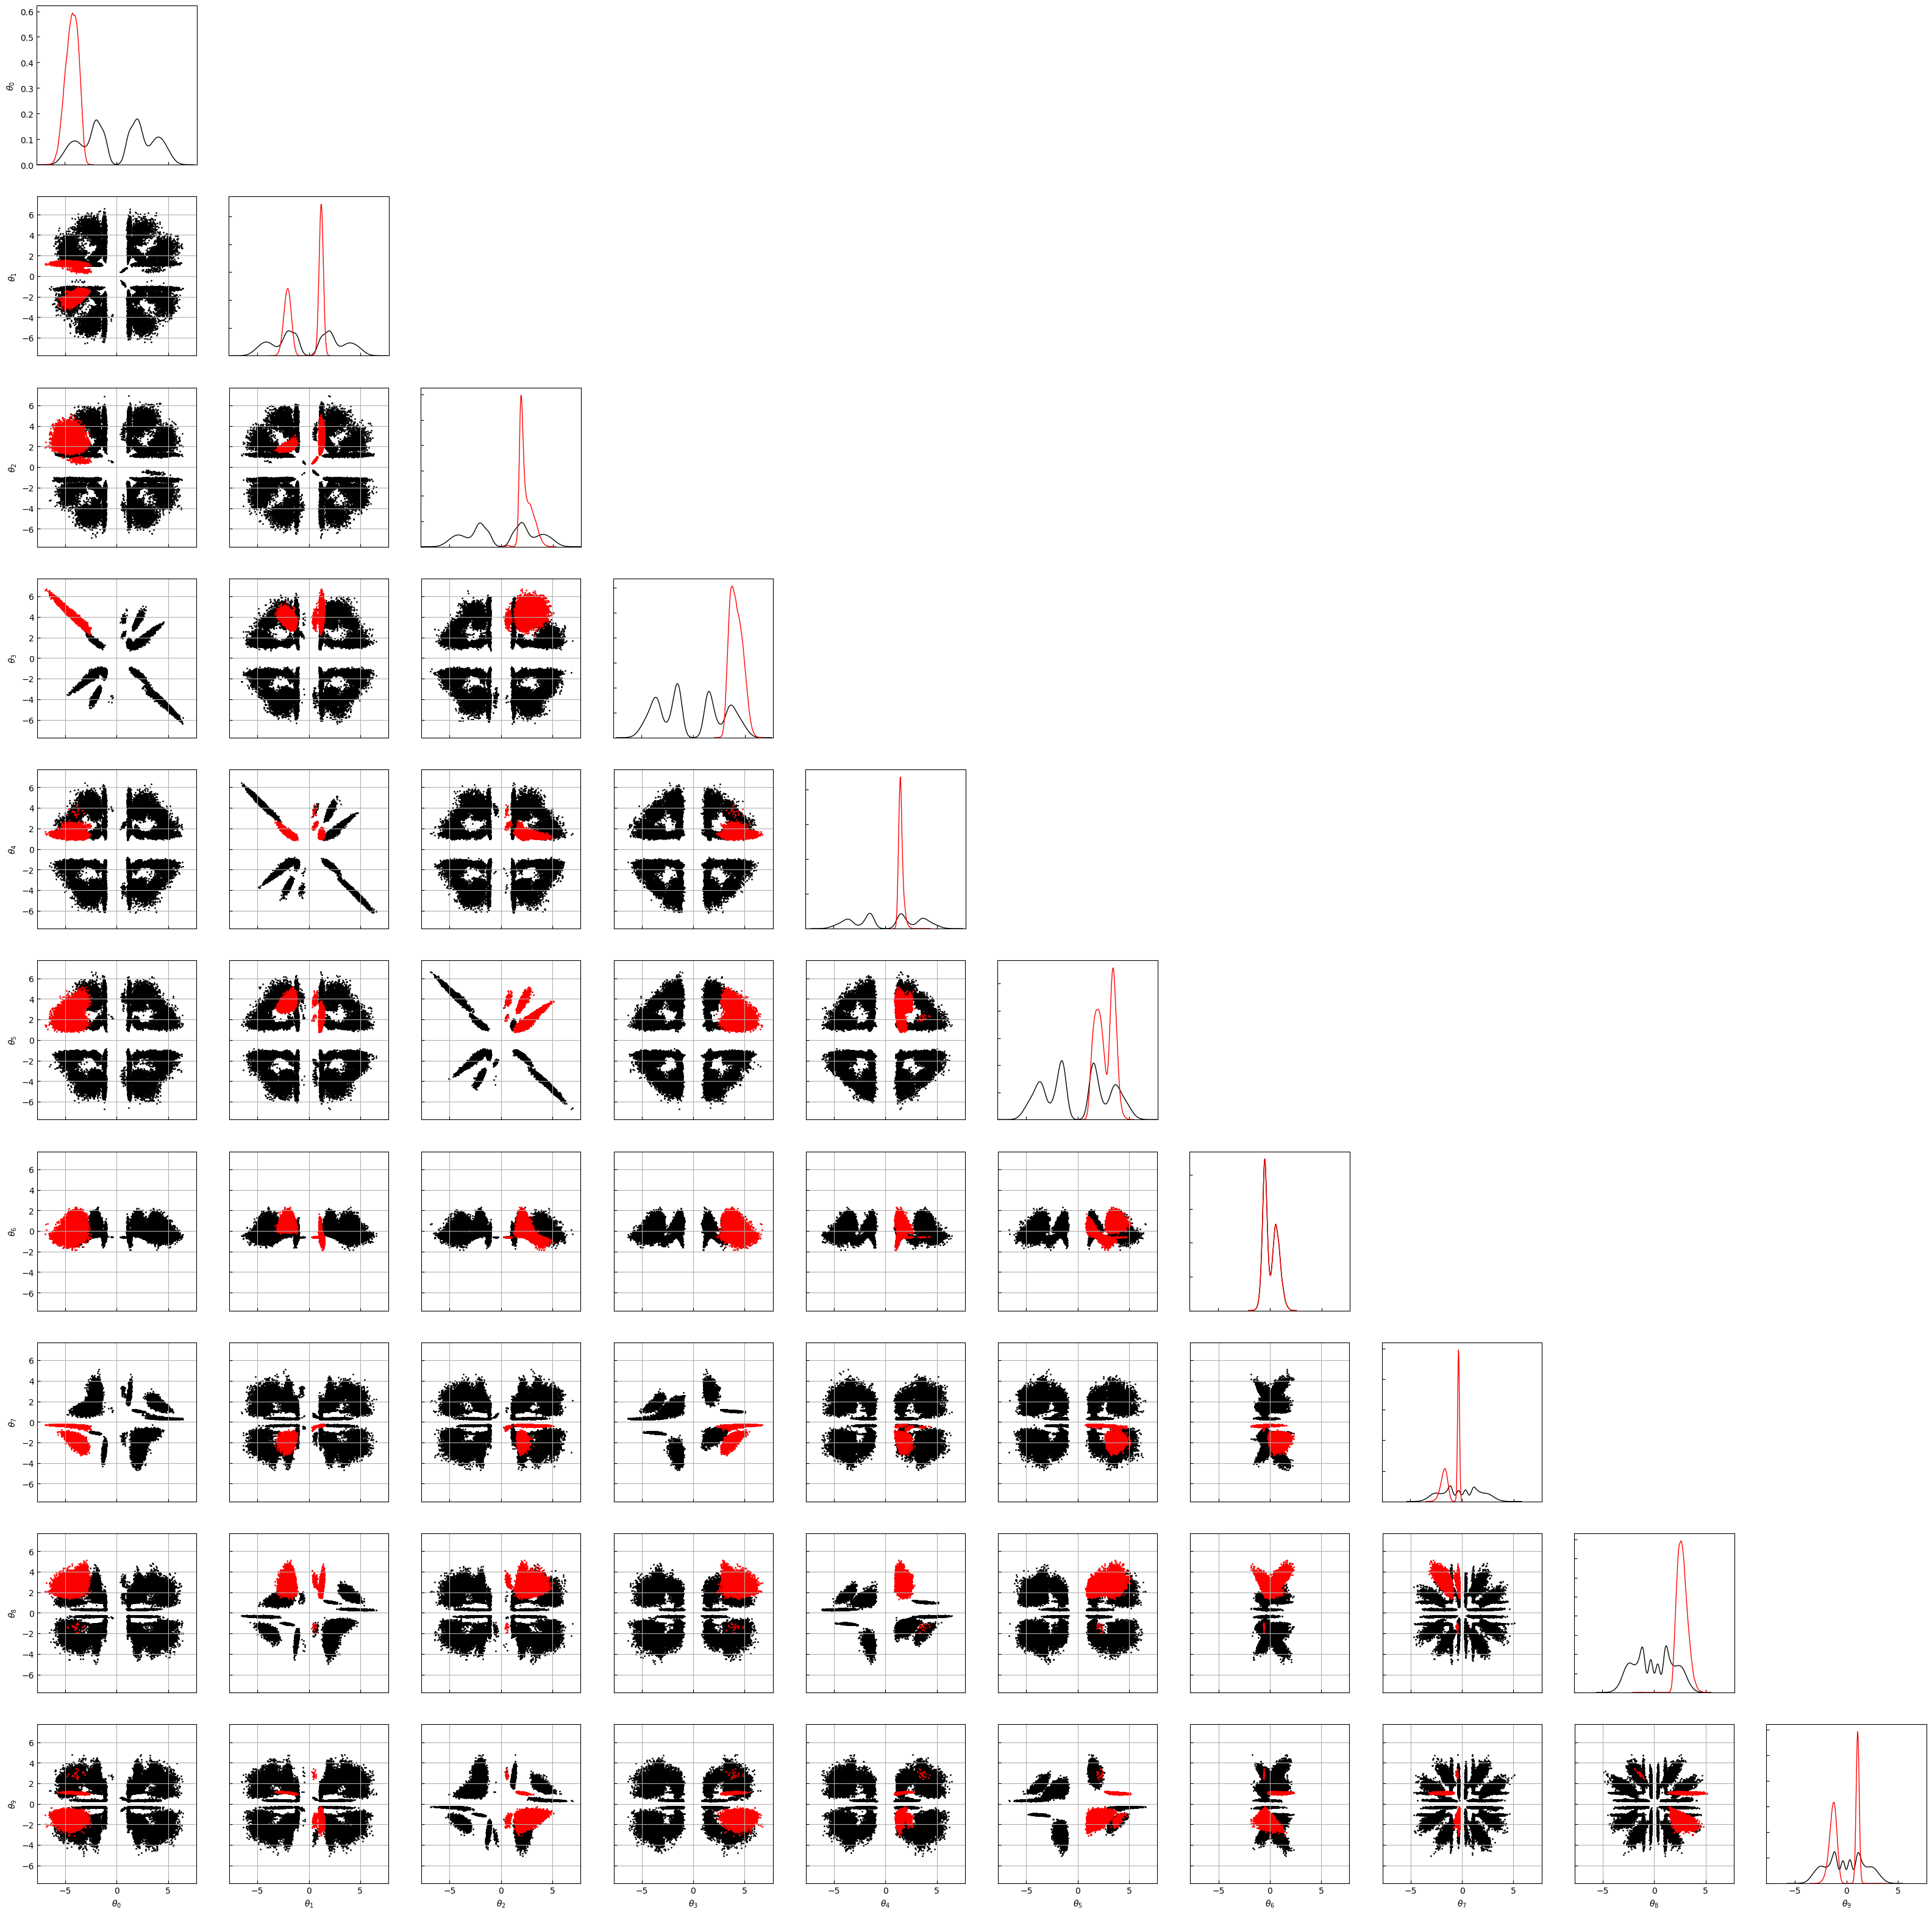

In [12]:
figure = visualization.TriangleFigure(
    prefix=r"\theta",
    ax_width=4.0,
    ax_height=4.0,
    settings=visualization.TriangleSettings(
        scatter_settings=visualization.ScatterSettings(alpha=1.0, size=1.0)
    )
)
figure.plot(data=parameters_samples, data_2=mirrored_parameters_samples)

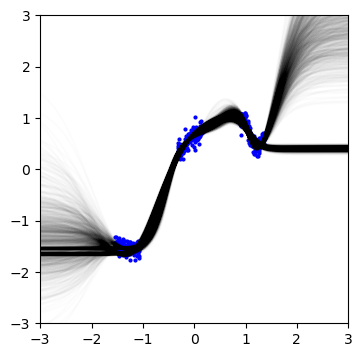

In [16]:
figure = visualization.RegressionFigure()
figure.plot(data=dataset_train.data, transformation=neural_network.apply_from_vector, parameters=mirrored_parameters_samples[:2048], std=0.1)

In [17]:
# reconstruct full posterior from all transformations

In [18]:
print(mirrored_parameters_samples.shape)
subset = mirrored_parameters_samples #[:4096]
fullset = []
counter = 0
for t1 in permutation_symmetries:
    for t2 in activation_symmetries:
        subset_transformed = subset @ t2 @ t1 # the order seems to be important!
        counter += 1
        fullset.append(subset_transformed)
fullset = np.concatenate(fullset, axis=0)
print(counter)

(49152, 10)
48


In [19]:
fullset = np.random.permutation(fullset)

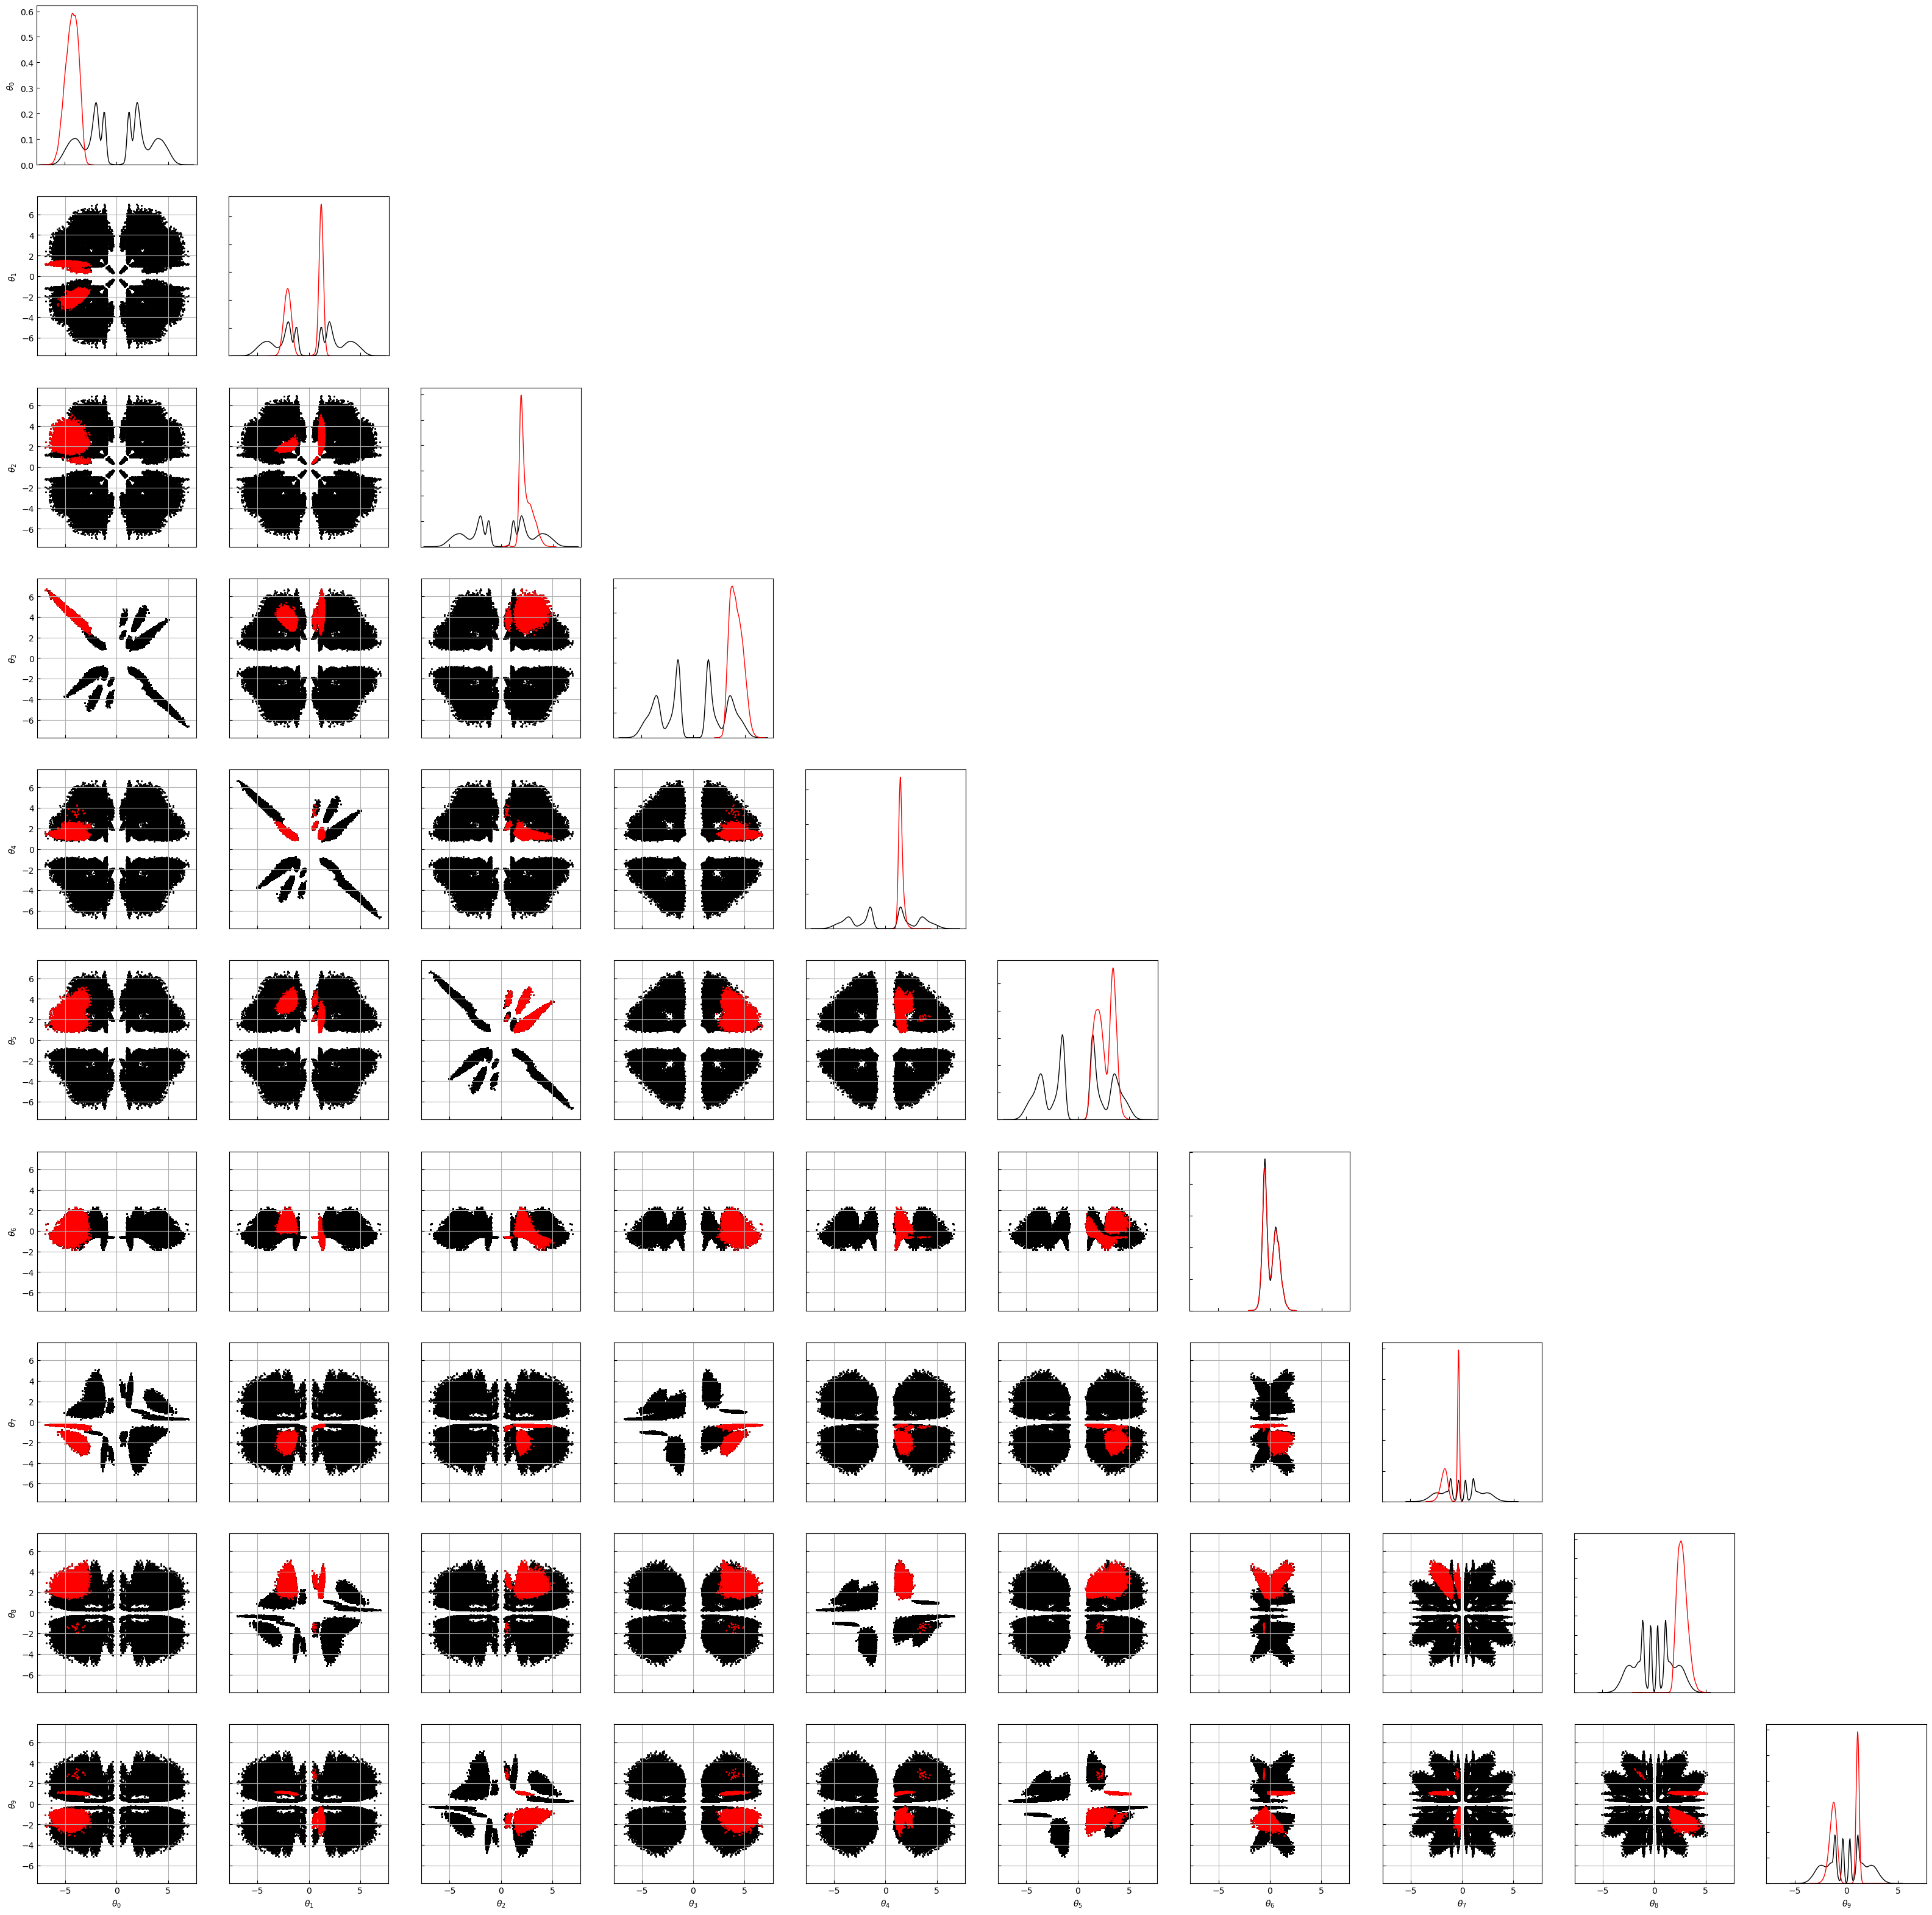

In [45]:
figure = visualization.TriangleFigure(
    prefix=r"\theta",
    ax_width=4.0,
    ax_height=4.0,
    settings=visualization.TriangleSettings(
        scatter_settings=visualization.ScatterSettings(alpha=1.0, size=1.0)
    )
)
figure.plot(data=fullset, data_2=subset)

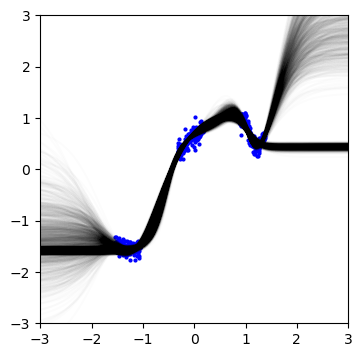

In [20]:
figure = visualization.RegressionFigure()
figure.plot(data=dataset_train.data, transformation=neural_network.apply_from_vector, parameters=fullset[:2048], std=0.1)

In [21]:
# disect non-symmetric area into smaller cluster

In [22]:
selection_1 = np.argwhere((mirrored_parameters_samples[:, 1] > 0.0) * 1.0).squeeze()
selection_2 = np.argwhere((mirrored_parameters_samples[:, 1] <= 0.0) * 1.0).squeeze()
set_1 = mirrored_parameters_samples[selection_1]
set_2 = mirrored_parameters_samples[selection_2]
print(set_1.shape, set_2.shape)
for i, (ele_1, ele_2) in enumerate(zip(set_1.mean(0), set_2.mean(0))):
    print(i, ele_1, "    ", ele_2)

(27717, 10) (21435, 10)
0 -4.6525216      -3.9024487
1 1.1921865      -2.0610883
2 2.677438      1.9695675
3 4.5148196      3.7062745
4 1.428717      1.5771017
5 2.0054433      3.4977243
6 -0.44833124      0.7204364
7 -0.33646432      -1.742781
8 2.526246      2.9545283
9 -1.3028702      1.0900602


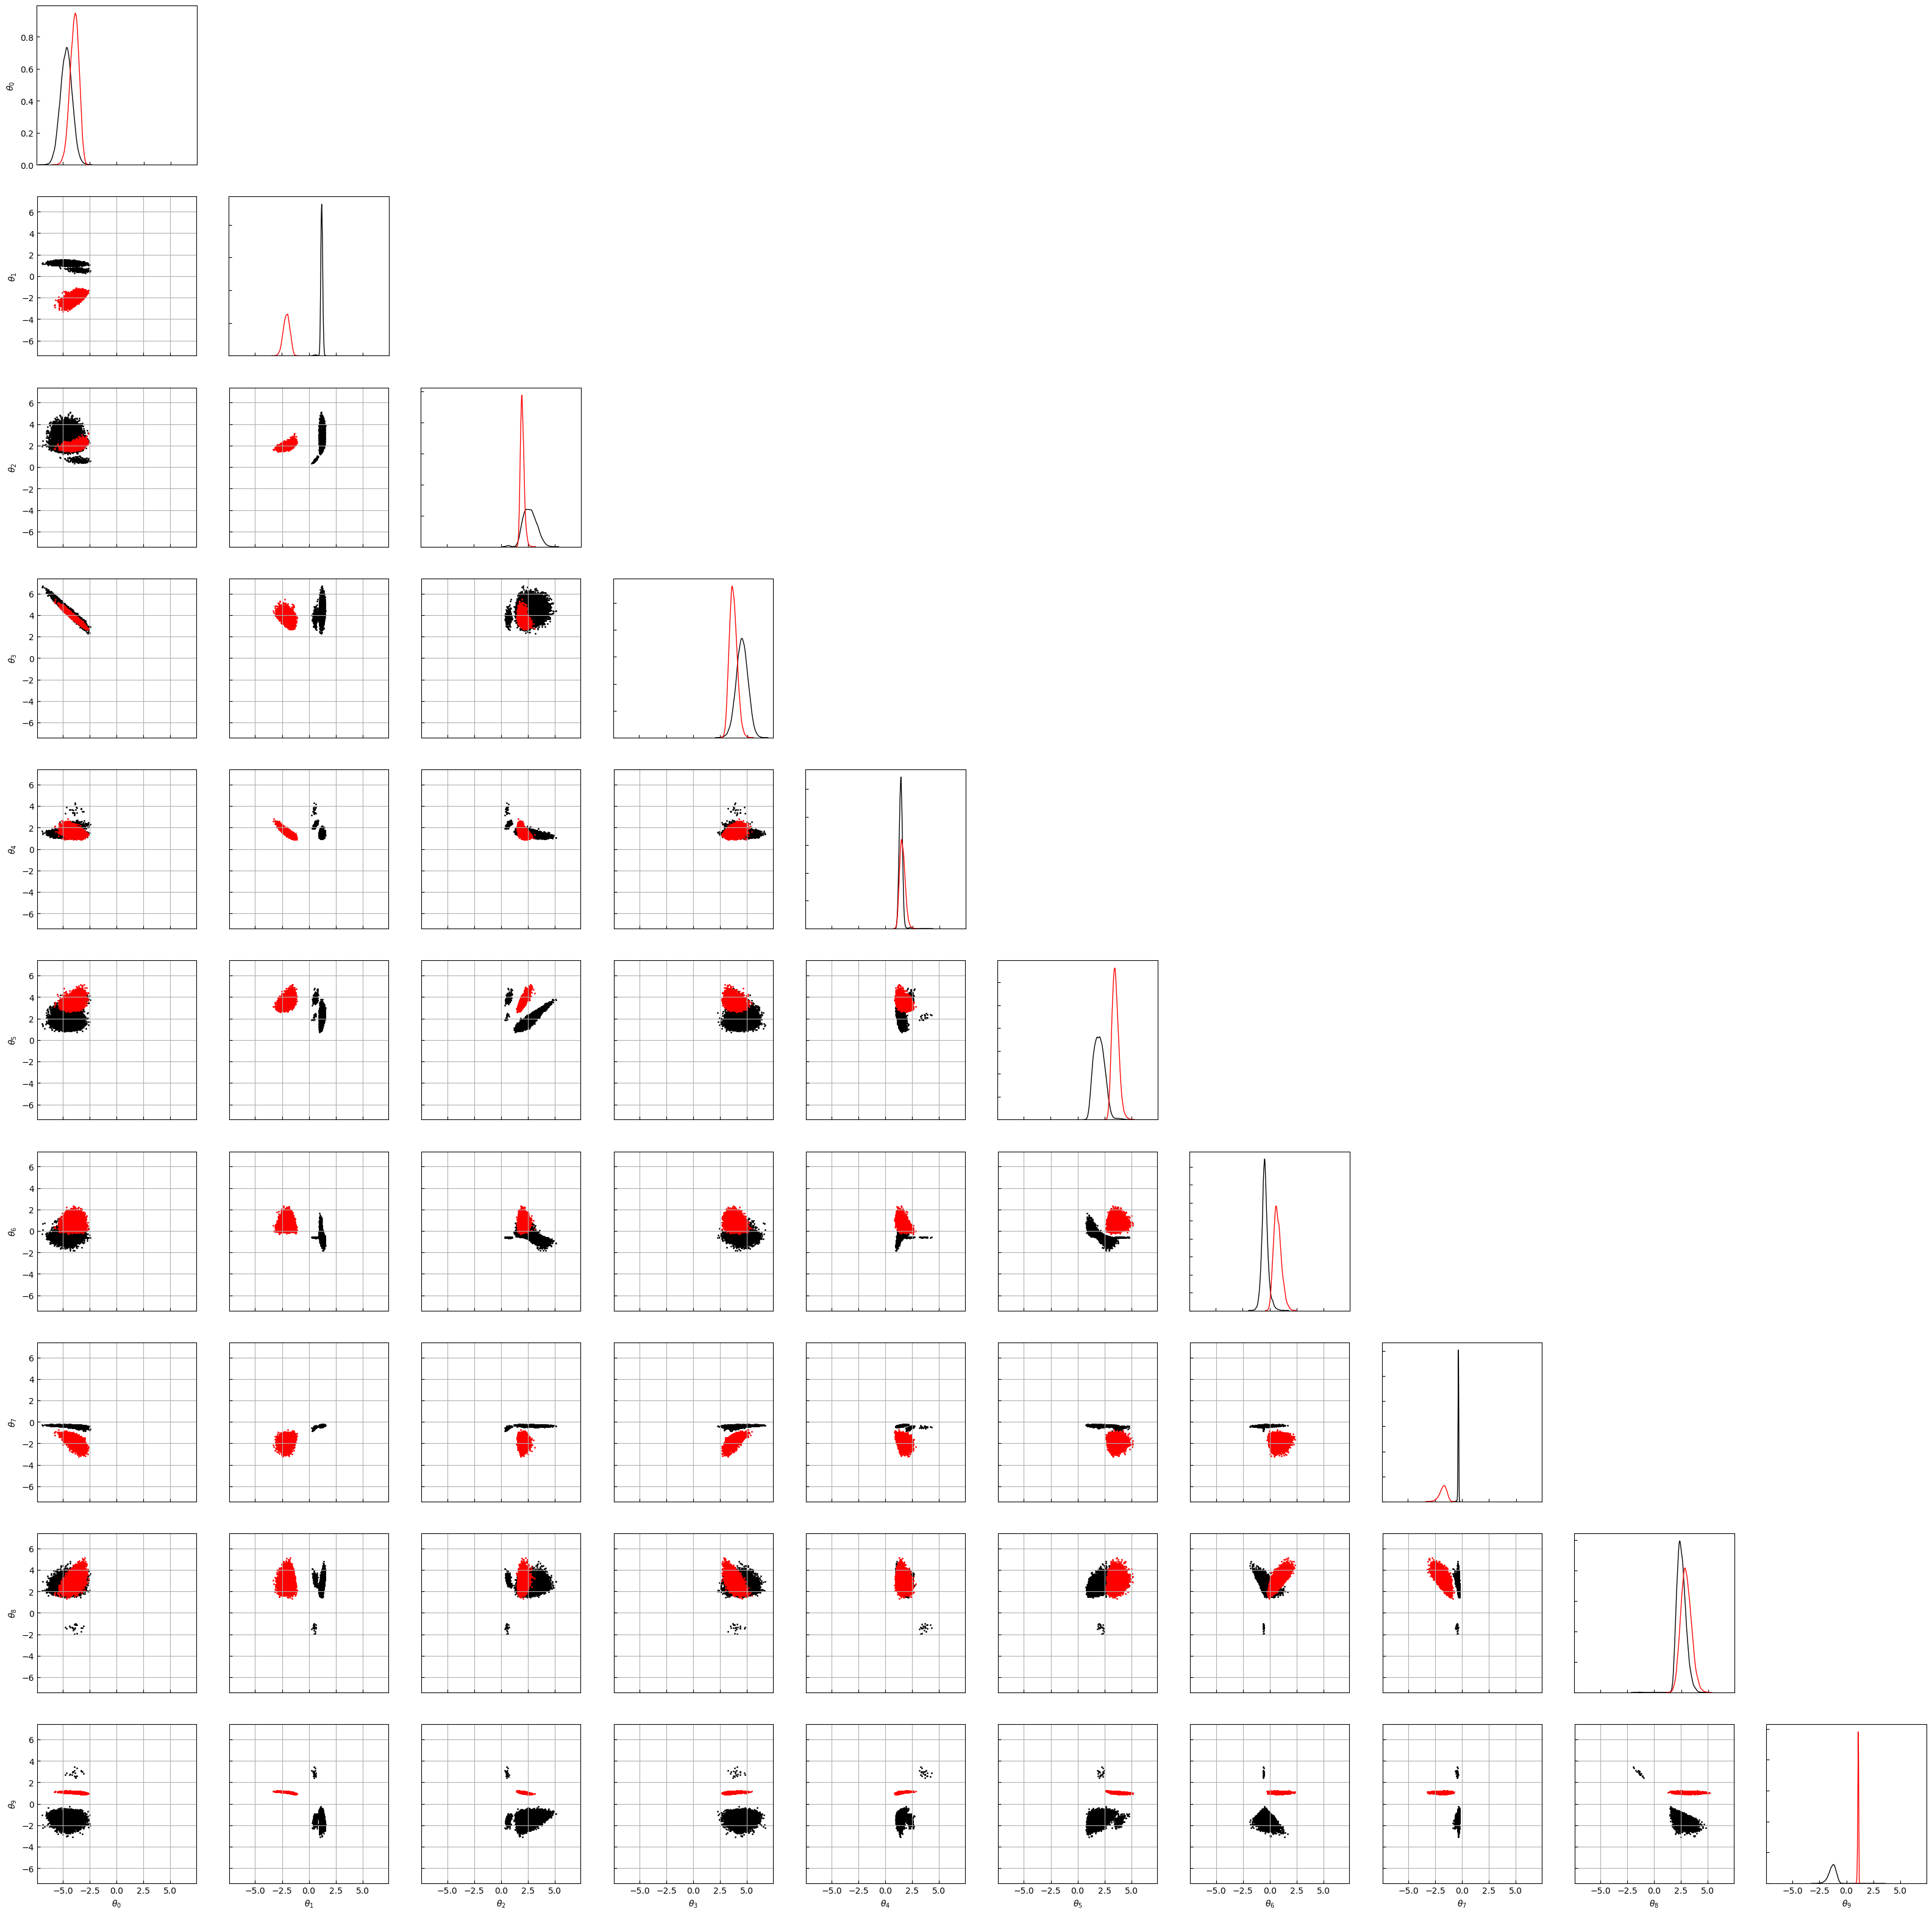

In [23]:
figure = visualization.TriangleFigure(
    prefix=r"\theta",
    ax_width=4.0,
    ax_height=4.0,
    settings=visualization.TriangleSettings(
        scatter_settings=visualization.ScatterSettings(alpha=1.0, size=1.0)
    )
)
figure.plot(data=set_1, data_2=set_2)

In [24]:
print(set_2.shape)
subset = set_2
fullset = []
counter = 0
for t1 in permutation_symmetries:
    for t2 in activation_symmetries:
        subset_transformed = subset @ t2 @ t1 # the order seems to be important!
        counter += 1
        fullset.append(subset_transformed)
fullset = np.concatenate(fullset, axis=0)
print(counter)

(21435, 10)
48


In [26]:
fullset = np.random.permutation(fullset)

In [30]:
set_2 = np.random.permutation(set_2)

In [32]:
set_1 = np.random.permutation(set_1)

In [ ]:
figure = visualization.TriangleFigure(
    prefix=r"\theta",
    ax_width=4.0,
    ax_height=4.0,
    settings=visualization.TriangleSettings(
        scatter_settings=visualization.ScatterSettings(alpha=1.0, size=1.0)
    )
)
figure.plot(data=fullset, data_2=subset)

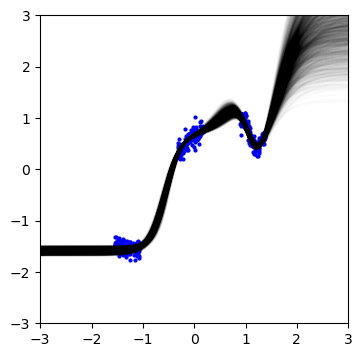

In [29]:
figure = visualization.RegressionFigure()
figure.plot(data=dataset_train.data, transformation=neural_network.apply_from_vector, parameters=fullset[:2048], std=0.1)

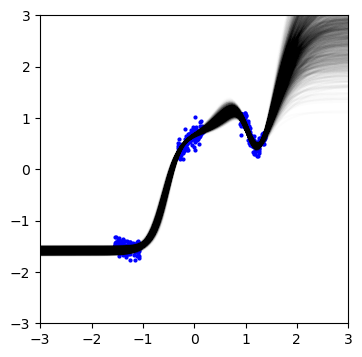

In [31]:
figure = visualization.RegressionFigure()
figure.plot(data=dataset_train.data, transformation=neural_network.apply_from_vector, parameters=set_2[:2048], std=0.1)

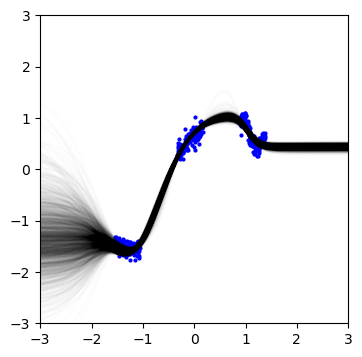

In [33]:
figure = visualization.RegressionFigure()
figure.plot(data=dataset_train.data, transformation=neural_network.apply_from_vector, parameters=set_1[:2048], std=0.1)

In [42]:
selection_3 = np.argwhere((set_1[:, 9] > 0.0) * 1.0).squeeze()
selection_4 = np.argwhere((set_1[:, 9] <= 0.0) * 1.0).squeeze()
set_1_a = set_1[selection_3]
set_1_b = set_1[selection_4]
print(set_1_a.shape, set_1_b.shape)

(22, 10) (27695, 10)


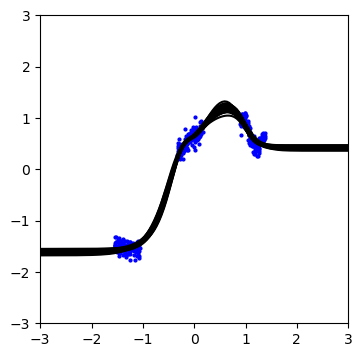

In [46]:
figure = visualization.RegressionFigure(settings=visualization.RegressionSettings(
    plot_settings=visualization.RegressionPlotSettings(plot_alpha=1.0)
))
figure.plot(data=dataset_train.data, transformation=neural_network.apply_from_vector, parameters=set_1_a[:2048], std=0.1)

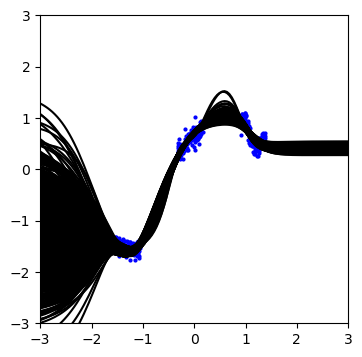

In [44]:
figure = visualization.RegressionFigure(settings=visualization.RegressionSettings(
    plot_settings=visualization.RegressionPlotSettings(plot_alpha=1.0)
))
figure.plot(data=dataset_train.data, transformation=neural_network.apply_from_vector, parameters=set_1_b[:2048], std=0.1)

In [63]:
print((set_1_b[:, 1]<0.8).sum())

181


In [64]:
selection_5 = np.argwhere((set_1_b[:, 1] > 0.8) * 1.0).squeeze()
selection_6 = np.argwhere((set_1_b[:, 1] <= 0.8) * 1.0).squeeze()
set_1_c = set_1_b[selection_5]
set_1_d = set_1_b[selection_6]
print(set_1_c.shape, set_1_d.shape)

(27514, 10) (181, 10)


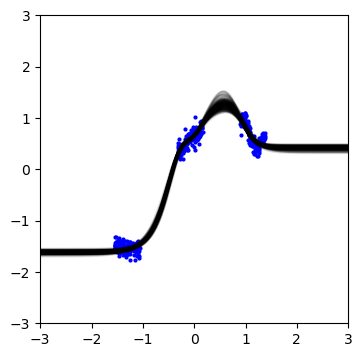

In [65]:
figure = visualization.RegressionFigure(settings=visualization.RegressionSettings(
    plot_settings=visualization.RegressionPlotSettings(plot_alpha=0.1)
))
figure.plot(data=dataset_train.data, transformation=neural_network.apply_from_vector, parameters=set_1_d[:2048], std=0.1)

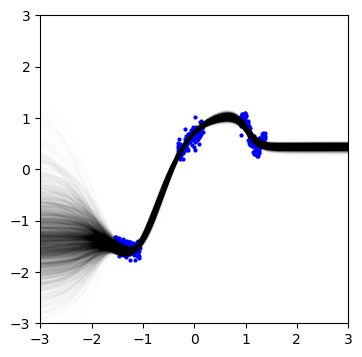

In [66]:
figure = visualization.RegressionFigure(settings=visualization.RegressionSettings(
    plot_settings=visualization.RegressionPlotSettings(plot_alpha=0.01)
))
figure.plot(data=dataset_train.data, transformation=neural_network.apply_from_vector, parameters=set_1_c[:2048], std=0.1)